In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import f_oneway, pearsonr

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

# Helpers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split

pd.options.display.max_columns = None

In [67]:
# add the movie notebook to path

full = pd.read_csv('../data/enriched_data.csv')
full.dropna(inplace=True)

mean_squared_error: 360028415537376.25
r2_score: 0.17365803833672178
explained_variance_score: 0.18586180388553186
mean_absolute_percentage_error: 19.773913359066714


Text(0.5, 1.0, 'Test')

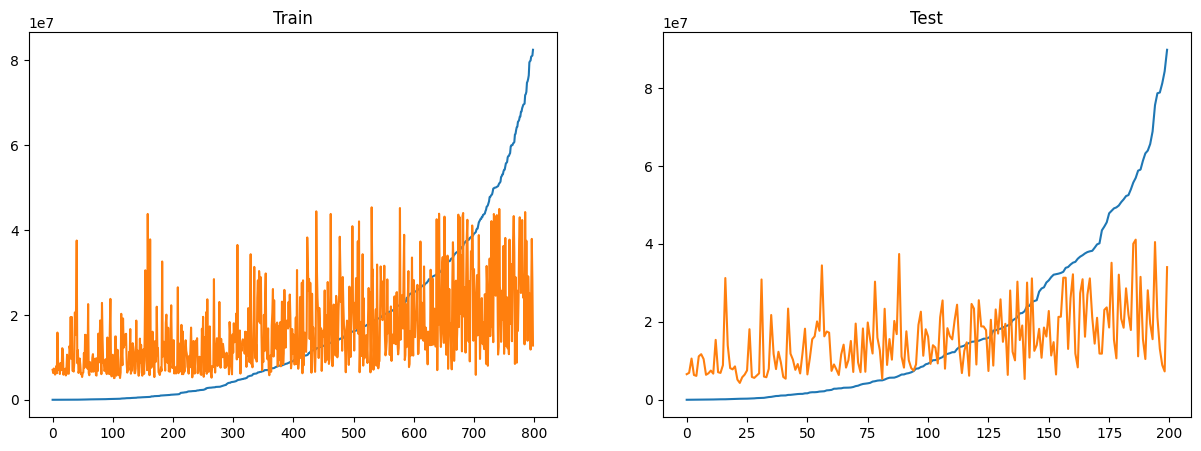

In [68]:
# Check statsmodels

import statsmodels.api as sm

X = full[["budget","duration"]]
y = full['gross']
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
model.summary()
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error

print(f"mean_squared_error: {mean_squared_error(y_test, y_pred)}")
print(f"r2_score: {r2_score(y_test, y_pred)}")
print(f"explained_variance_score: {explained_variance_score(y_test, y_pred)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, y_pred)}")

y_train = y_train.sort_values()
X_train = X_train.loc[y_train.index]
y_test = y_test.sort_values()
X_test = X_test.loc[y_test.index]

for dataset in [y_train, X_train, y_test, X_test]:
    dataset.reset_index(drop=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(y_train)
ax1.plot(model.predict(X_train))
ax1.set_title('Train')
ax2.plot(y_test)
ax2.plot(model.predict(X_test))
ax2.set_title('Test')

In [69]:
prefix = ''
target = 'gross'
only_significant = True
reg = Pipeline([
    # ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

In [70]:

y = full[target]
X = full.drop(columns=[target])

pred = [
    'duration', 'director_facebook_likes',
    'actor_3_facebook_likes', 'actor_1_facebook_likes',
    'cast_total_facebook_likes', 'budget',
    'actor_2_facebook_likes', 'genre_Drama', 'genre_Comedy', 'genre_Romance',
    'genre_Thriller', 'genre_Crime', 'genre_Action', 'genre_Adventure',
    'genre_Horror', 'genre_Family', 'genre_Fantasy', 'genre_Other',
    'pop_est', 'gdp_md', 'actor_1_degree', 'actor_1_closeness',
    'actor_1_betweenness', 'actor_2_degree', 'actor_2_closeness',
    'actor_2_betweenness', 'actor_3_degree', 'actor_3_closeness',
    'actor_3_betweenness']

corr = pd.DataFrame(columns=['corr', 'p-value'])
for p in pred:
    if p in X.columns:
        ctest = pearsonr(full[p], y)
        corr.loc[p] = ctest
corr["significant"] = corr["p-value"] < 0.05

corr["abs_corr"] = corr["corr"].abs()
max_corr = corr.abs_corr.max()

corr.sort_values(by='p-value')


,corr,p-value,significant,abs_corr
budget,0.480309,8.694141e-59,True,0.480309
cast_total_facebook_likes,0.244441,4.668336e-15,True,0.244441
genre_Family,0.226441,4.407737e-13,True,0.226441
actor_3_facebook_likes,0.217387,3.769313e-12,True,0.217387
actor_2_facebook_likes,0.204573,6.711428e-11,True,0.204573
genre_Adventure,0.195870,4.274117e-10,True,0.195870
actor_1_facebook_likes,0.189878,1.456868e-09,True,0.189878
genre_Drama,-0.175028,2.573509e-08,True,0.175028
gdp_md,0.173474,3.428867e-08,True,0.173474
actor_1_degree,0.133006,2.471345e-05,True,0.133006


In [71]:
if only_significant:
    pred = corr[corr["significant"]].index
X = X[pred]

In [73]:
X = pd.get_dummies(X)
X.head()

,duration,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,budget,actor_2_facebook_likes,genre_Drama,genre_Comedy,genre_Action,genre_Adventure,genre_Family,pop_est,gdp_md,actor_1_degree,actor_1_closeness,actor_1_betweenness,actor_2_degree,actor_2_closeness,actor_3_closeness
0,110,393.0,623.0,1722,10000000,508.0,True,False,False,False,False,328239523.0,21433226.0,6.0,0.076890,0.004953,6.0,0.083578,0.073669
1,104,7.0,67.0,152,40000000,63.0,True,False,False,False,False,67059887.0,2715518.0,4.0,0.001978,0.000003,2.0,0.001319,0.001319
2,125,394.0,613.0,1970,50000000,422.0,False,False,False,False,False,328239523.0,21433226.0,2.0,0.000879,0.000000,2.0,0.000879,0.000879
3,134,249.0,919.0,1695,55000000,303.0,False,False,True,True,False,328239523.0,21433226.0,4.0,0.077327,0.005738,3.0,0.069717,0.071350
4,111,6.0,433.0,679,60000000,208.0,False,False,False,False,False,328239523.0,21433226.0,2.0,0.000879,0.000000,2.0,0.000879,0.000879


In [74]:
# Check statsmodels

import statsmodels.api as sm

# replace all boolean columns with 0 and 1

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
model.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

mean_squared_error: 345745446309527.6
r2_score: 0.20644049744484572
explained_variance_score: 0.22102457247840013
mean_absolute_percentage_error: 18.92807008248547


Text(0.5, 1.0, 'Test')

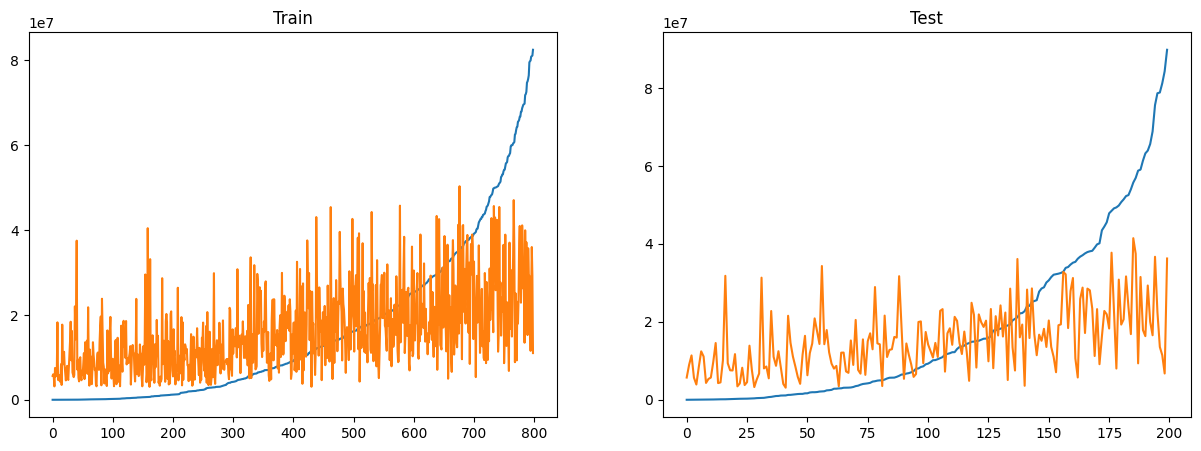

In [58]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error

print(f"mean_squared_error: {mean_squared_error(y_test, y_pred)}")
print(f"r2_score: {r2_score(y_test, y_pred)}")
print(f"explained_variance_score: {explained_variance_score(y_test, y_pred)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, y_pred)}")

y_train = y_train.sort_values()
X_train = X_train.loc[y_train.index]
y_test = y_test.sort_values()
X_test = X_test.loc[y_test.index]

for dataset in [y_train, X_train, y_test, X_test]:
    dataset.reset_index(drop=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(y_train)
ax1.plot(model.predict(X_train))
ax1.set_title('Train')
ax2.plot(y_test)
ax2.plot(model.predict(X_test))
ax2.set_title('Test')

In [ ]:


scoring = {
    'r2': 'r2',
    'n_mape': 'neg_mean_absolute_percentage_error',
    'n_mse': 'neg_mean_squared_error'
}

model_params = {
    'estimator': reg,
    'X': X,
    'y': y,
    'cv': 4,
    'scoring': scoring,
}

scores = cross_validate(
    **model_params
)

print(model_params['estimator'][-1].__class__.__name__)
print("R2: ", scores['test_r2'].mean())
print("MAPE: ", -scores['test_n_mape'].mean())
print("MSE: ", -scores['test_n_mse'].mean())

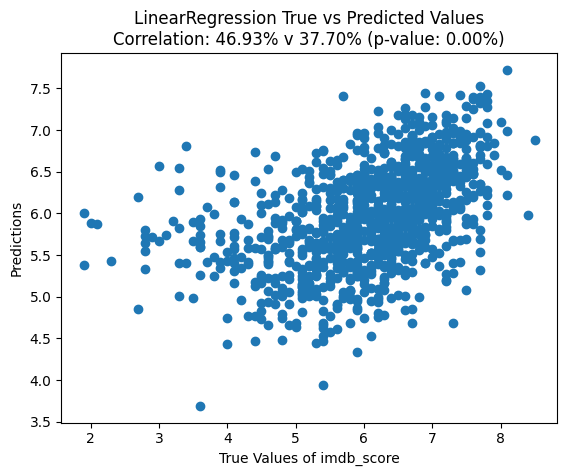

In [110]:
if "scoring" in model_params.keys():
    del model_params['scoring']

y_pred = cross_val_predict(
    **model_params
)

ctest_mod = pearsonr(y, y_pred)

plt.scatter(y, y_pred)
plt.xlabel(f'True Values of {target}')
plt.ylabel('Predictions')
plt.title("".join([
    f'{model_params["estimator"][-1].__class__.__name__} True vs Predicted Values',
    f"\nCorrelation: {ctest_mod[0]:.2%} v {max_corr:.2%} (p-value: {ctest_mod[1]:.2%})"
])),
plt.savefig(f'../figures/{prefix}{model_params["estimator"][-1].__class__.__name__}_{target}.png')
plt.show()



In [111]:
log = pd.DataFrame(columns=[
    'accuracy', 'average_precision', 'roc_auc', 'recall', 'precision'])

In [112]:
# Import classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

full['profitable'] = full['profit'] > 0
full['profitable'] = full['profitable'].astype(int)
full['profitable'].value_counts(normalize=True)

y = full['profitable']
X = X[pred]

scoring = {
    'accuracy': 'accuracy',
    'average_precision': 'average_precision',
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision',
}

scores = cross_validate(
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", model)
        ]
    ),
    X,
    y,
    cv=5,
    scoring=scoring
)

log.loc[model.__class__.__name__] = [
    scores['test_accuracy'].mean(),
    scores['test_average_precision'].mean(),
    scores['test_roc_auc'].mean(),
    scores['test_recall'].mean(),
    scores['test_precision'].mean()
]


KeyError: 'profit'

In [ ]:
# log.to_csv(f'../figures/profitable.csv')